# Setup

In [1]:
# give colab permission to access drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# required for odeformer, although it's annoying to run these so i made the required changes in odeformer
%pip install torch==2.0.0
%pip install numpy==1.23.5

# changed arg weights_only = False in torch.load in sklearn_wrapper to fix a loading error from running dstr = odeformer.model.SymbolicTransformerRegressor, i.e.
# model = torch.load(model_path, weights_only=False)

# also changed np.infty to np.inf

In [ ]:
# replace with your drive paths to MIVLE repo, odeformer repo, and shared probing_data folder
repo_path = '/content/drive/MyDrive/aisc/repos/MIVLDE/subteams/LLMProbing'
odeformer_path = '/content/drive/MyDrive/aisc/repos/odeformer'
samples_path = '/content/drive/MyDrive/aisc/probing_data/samples/derivatives'
activations_path = '/content/drive/MyDrive/aisc/probing_data/activations/derivatives'
probes_path = '/content/drive/MyDrive/aisc/probing_data/probes/derivatives'

In [ ]:
import sys
import importlib
sys.path.append(repo_path)
sys.path.append(odeformer_path)
import numpy as np
import os
import pickle

In [ ]:
import odeformer.model
dstr = odeformer.model.SymbolicTransformerRegressor(from_pretrained=True)
model_args = {'beam_size': 10, 'beam_temperature': 0.8} # higher beam temp seems to be better for avoiding nans in solutions
dstr.set_model_args(model_args)

Downloading...
From (original): https://drive.google.com/uc?id=1L_UZ0qgrBVkRuhg5j3BQoGxlvMk_Pm1W
From (redirected): https://drive.google.com/uc?id=1L_UZ0qgrBVkRuhg5j3BQoGxlvMk_Pm1W&confirm=t&uuid=51ffcd68-22cc-49e0-8554-307ce91b2046
To: /content/odeformer.pt
100%|██████████| 465M/465M [00:06<00:00, 73.3MB/s]


Loaded pretrained model


# Generate samples

In [ ]:
from src.sample_generation import ManualSamplesGenerator
msg = ManualSamplesGenerator(samples_path=samples_path)

In [ ]:
# Times array
t_values = np.linspace(1, 10, 50)

# Exponential parameters
c_values = np.linspace(1,10, 10)
a_values = np.linspace(0,10,51)


In [ ]:
# Generate exponential samples
msg.generate_exponential_samples(t_values, c_values, a_values)

Generating exponential samples:   0%|          | 0/510 [00:00<?, ?it/s]

Saving generated samples: 510it [00:05, 97.46it/s] 


[INFO] Data generation complete. Saved 510 exponential samples to /content/drive/MyDrive/aisc/probing_data/samples/derivatives


In [ ]:
# Inspect an exponential sample to see its keys and some data
samples_dir = os.fsencode(samples_path)
for sample_file in os.listdir(samples_dir):
  sample_name = os.fsdecode(sample_file)
  if "exp" in sample_name:
    exp_sample_path = os.path.join(samples_path, sample_name)
    with open(exp_sample_path, 'rb') as f:
        exp_sample = pickle.load(f)
    print(exp_sample.keys())
    print(exp_sample['expression'])
    print(exp_sample['feature_dict'])
    break

dict_keys(['times', 'trajectory', 'parameters', 'feature_dict', 'expression'])
1.0 * np.exp(-0.0 * t)
{'exponential': 1, 'hyperbolic': 0, 'derivative_0': -0.0, 'derivative_3': -0.0}


# Activation extraction

In [ ]:
from src.activation_extraction import ActivationsExtractor

In [ ]:
act_extractor = ActivationsExtractor()

In [ ]:
act_extractor.extract_activations(dstr, samples_path, activations_path, layers_to_extract=['ffn'])

Extracting Activations: 100%|██████████| 510/510 [1:03:51<00:00,  7.51s/it]


[INFO] Activation extraction complete. Activations saved to /content/drive/MyDrive/aisc/probing_data/activations/derivatives


In [ ]:
# check how many of the samples have R^2 > -1
manual_acts_dir = os.fsencode(activations_path)
cnt = 0
cnt_all = 0
for acts_file in os.listdir(manual_acts_dir):
  acts_name = os.fsdecode(acts_file)
  manual_acts_path = os.path.join(activations_path, acts_name)
  with open(manual_acts_path, 'rb') as f:
      manual_acts = pickle.load(f)
  # print(manual_acts.keys())
  # print(manual_acts['feature_dict'])
  # # print(manual_acts['r2_score'])
  # print(manual_acts['expression'])
  # print(manual_acts['pred_expression'])
  if manual_acts['feature_dict']['r2_score'] > -1:
    cnt+=1
  cnt_all +=1
print(cnt, cnt_all)

481 510


In [ ]:
# compute mean derivative_0 and derivative_3
manual_acts_dir = os.fsencode(activations_path)
cnt = 0
deriv0 = 0
deriv3 = 0
for acts_file in os.listdir(manual_acts_dir):
  acts_name = os.fsdecode(acts_file)
  manual_acts_path = os.path.join(activations_path, acts_name)
  with open(manual_acts_path, 'rb') as f:
      manual_acts = pickle.load(f)
  # print(manual_acts.keys())
  # print(manual_acts['feature_dict'])
  # # print(manual_acts['r2_score'])
  # print(manual_acts['expression'])
  # print(manual_acts['pred_expression'])
  if manual_acts['feature_dict']['r2_score'] > -1:
    cnt+=1
    deriv0 += manual_acts['feature_dict']['derivative_0']
    deriv3 += manual_acts['feature_dict']['derivative_3']
deriv0 /= cnt
deriv3 /= cnt
print(cnt, deriv0, deriv3)

481 -0.5645637115194334 -0.23552387617428366


In [ ]:
activations_path

'/content/drive/MyDrive/aisc/probing_data/activations/derivatives'

# Train probes

In [ ]:
import experiments

In [ ]:
target_feature = 'derivative_0'
lr = 0.01
num_epochs = 20
num_repeats = 3
r2_threshold = -1
layers = [idx for idx in range(0, 16)]
probes_path_0 = probes_path + '/derivative_0'

In [ ]:
expt_results = experiments.scalar_prediction_experiment(target_feature=target_feature, activations_path=activations_path, \
                     probes_path=probes_path_0, \
                     lr=lr, num_epochs=num_epochs, \
                     layers=layers, num_repeats=num_repeats, r2_threshold=r2_threshold)
# save experiment results
with open(f'{probes_path_0}/experiment_data.pt', 'wb') as f:
    pickle.dump(expt_results, f)

Repeat 0 of layer 0



Training LR Probe: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]



Training Set (Epoch 20 - Final): Loss 2.1783579978075895
Regression probe trained on layer 0: Test Set Loss 24.123253635145375
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_0_0.pt
Repeat 1 of layer 0



Training LR Probe: 100%|██████████| 20/20 [01:18<00:00,  3.93s/it]



Training Set (Epoch 20 - Final): Loss 7.599013962683739
Regression probe trained on layer 0: Test Set Loss 52.06075300628678
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_0_1.pt
Repeat 2 of layer 0



Training LR Probe: 100%|██████████| 20/20 [01:18<00:00,  3.94s/it]



Training Set (Epoch 20 - Final): Loss 9.76712274922953
Regression probe trained on layer 0: Test Set Loss 348.78643894195557
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_0_2.pt
Repeat 0 of layer 1



Training LR Probe: 100%|██████████| 20/20 [01:11<00:00,  3.57s/it]



Training Set (Epoch 20 - Final): Loss 0.6078008856092181
Regression probe trained on layer 1: Test Set Loss 18.287918973811127
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_1_0.pt
Repeat 1 of layer 1



Training LR Probe: 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]



Training Set (Epoch 20 - Final): Loss 5.858092199904578
Regression probe trained on layer 1: Test Set Loss 106.8430399581169
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_1_1.pt
Repeat 2 of layer 1



Training LR Probe: 100%|██████████| 20/20 [01:11<00:00,  3.55s/it]



Training Set (Epoch 20 - Final): Loss 21.61544267295243
Regression probe trained on layer 1: Test Set Loss 103.76509747254507
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_1_2.pt
Repeat 0 of layer 2



Training LR Probe: 100%|██████████| 20/20 [01:17<00:00,  3.87s/it]



Training Set (Epoch 20 - Final): Loss 41.986455664696635
Regression probe trained on layer 2: Test Set Loss 307.73798425123096
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_2_0.pt
Repeat 1 of layer 2



Training LR Probe: 100%|██████████| 20/20 [01:15<00:00,  3.78s/it]



Training Set (Epoch 20 - Final): Loss 37.724398261231265
Regression probe trained on layer 2: Test Set Loss 539.2447506169943
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_2_1.pt
Repeat 2 of layer 2



Training LR Probe: 100%|██████████| 20/20 [01:14<00:00,  3.74s/it]



Training Set (Epoch 20 - Final): Loss 81.50257005567674
Regression probe trained on layer 2: Test Set Loss 965.9775354083782
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_2_2.pt
Repeat 0 of layer 3



Training LR Probe: 100%|██████████| 20/20 [01:18<00:00,  3.90s/it]



Training Set (Epoch 20 - Final): Loss 0.00987000163983215
Regression probe trained on layer 3: Test Set Loss 0.5997253906710588
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_3_0.pt
Repeat 1 of layer 3



Training LR Probe: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]



Training Set (Epoch 20 - Final): Loss 0.007078420738508175
Regression probe trained on layer 3: Test Set Loss 0.9717498717639804
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_3_1.pt
Repeat 2 of layer 3



Training LR Probe: 100%|██████████| 20/20 [01:10<00:00,  3.52s/it]



Training Set (Epoch 20 - Final): Loss 0.018511980375299206
Regression probe trained on layer 3: Test Set Loss 0.7780173132762987
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_3_2.pt
Repeat 0 of layer 4



Training LR Probe: 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]



Training Set (Epoch 20 - Final): Loss 0.04014079768011081
Regression probe trained on layer 4: Test Set Loss 3.8131662976084044
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_4_0.pt
Repeat 1 of layer 4



Training LR Probe: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]



Training Set (Epoch 20 - Final): Loss 0.26469134301334235
Regression probe trained on layer 4: Test Set Loss 0.9247880116878756
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_4_1.pt
Repeat 2 of layer 4



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]



Training Set (Epoch 20 - Final): Loss 0.3103080489263755
Regression probe trained on layer 4: Test Set Loss 2.742481591100841
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_4_2.pt
Repeat 0 of layer 5



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.35s/it]



Training Set (Epoch 20 - Final): Loss 0.13254346890108926
Regression probe trained on layer 5: Test Set Loss 1.7688046857947484
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_5_0.pt
Repeat 1 of layer 5



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]



Training Set (Epoch 20 - Final): Loss 0.03851872984465066
Regression probe trained on layer 5: Test Set Loss 0.43647177399323783
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_5_1.pt
Repeat 2 of layer 5



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]



Training Set (Epoch 20 - Final): Loss 0.2781872566257204
Regression probe trained on layer 5: Test Set Loss 0.6935187462562075
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_5_2.pt
Repeat 0 of layer 6



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]



Training Set (Epoch 20 - Final): Loss 0.022085907377979972
Regression probe trained on layer 6: Test Set Loss 0.30364041397115216
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_6_0.pt
Repeat 1 of layer 6



Training LR Probe: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]



Training Set (Epoch 20 - Final): Loss 0.023009495030749928
Regression probe trained on layer 6: Test Set Loss 0.6525909539165392
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_6_1.pt
Repeat 2 of layer 6



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.46s/it]



Training Set (Epoch 20 - Final): Loss 0.06245875358581543
Regression probe trained on layer 6: Test Set Loss 0.6419348653960242
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_6_2.pt
Repeat 0 of layer 7



Training LR Probe: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]



Training Set (Epoch 20 - Final): Loss 0.01885469551984366
Regression probe trained on layer 7: Test Set Loss 0.3974370189728991
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_7_0.pt
Repeat 1 of layer 7



Training LR Probe: 100%|██████████| 20/20 [01:16<00:00,  3.85s/it]



Training Set (Epoch 20 - Final): Loss 0.021271242240032594
Regression probe trained on layer 7: Test Set Loss 0.7466741446599675
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_7_1.pt
Repeat 2 of layer 7



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]



Training Set (Epoch 20 - Final): Loss 0.02437815735866497
Regression probe trained on layer 7: Test Set Loss 0.3136712015023022
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_7_2.pt
Repeat 0 of layer 8



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.45s/it]



Training Set (Epoch 20 - Final): Loss 0.026991830069523354
Regression probe trained on layer 8: Test Set Loss 0.340678539244512
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_8_0.pt
Repeat 1 of layer 8



Training LR Probe: 100%|██████████| 20/20 [01:05<00:00,  3.27s/it]



Training Set (Epoch 20 - Final): Loss 0.020671398811913155
Regression probe trained on layer 8: Test Set Loss 0.5466308342874981
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_8_1.pt
Repeat 2 of layer 8



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.30s/it]



Training Set (Epoch 20 - Final): Loss 0.02457068897299952
Regression probe trained on layer 8: Test Set Loss 0.4314579782506674
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_8_2.pt
Repeat 0 of layer 9



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.32s/it]



Training Set (Epoch 20 - Final): Loss 0.023730078523422217
Regression probe trained on layer 9: Test Set Loss 0.3144658142858437
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_9_0.pt
Repeat 1 of layer 9



Training LR Probe: 100%|██████████| 20/20 [01:05<00:00,  3.27s/it]



Training Set (Epoch 20 - Final): Loss 0.01874908868755613
Regression probe trained on layer 9: Test Set Loss 0.31720276803995756
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_9_1.pt
Repeat 2 of layer 9



Training LR Probe: 100%|██████████| 20/20 [01:05<00:00,  3.29s/it]



Training Set (Epoch 20 - Final): Loss 0.019042295730346208
Regression probe trained on layer 9: Test Set Loss 0.4052282349991856
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_9_2.pt
Repeat 0 of layer 10



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.32s/it]



Training Set (Epoch 20 - Final): Loss 0.13671295252906812
Regression probe trained on layer 10: Test Set Loss 0.82463585338625
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_10_0.pt
Repeat 1 of layer 10



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]



Training Set (Epoch 20 - Final): Loss 0.02550196282855876
Regression probe trained on layer 10: Test Set Loss 0.42605370161375805
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_10_1.pt
Repeat 2 of layer 10



Training LR Probe: 100%|██████████| 20/20 [01:12<00:00,  3.65s/it]



Training Set (Epoch 20 - Final): Loss 0.02174984970456594
Regression probe trained on layer 10: Test Set Loss 0.5034058299690969
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_10_2.pt
Repeat 0 of layer 11



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]



Training Set (Epoch 20 - Final): Loss 0.018763149810301794
Regression probe trained on layer 11: Test Set Loss 0.40809739477112555
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_11_0.pt
Repeat 1 of layer 11



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]



Training Set (Epoch 20 - Final): Loss 0.12157330309681885
Regression probe trained on layer 11: Test Set Loss 0.8188958530906044
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_11_1.pt
Repeat 2 of layer 11



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]



Training Set (Epoch 20 - Final): Loss 0.028608390553431076
Regression probe trained on layer 11: Test Set Loss 0.3656462843670549
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_11_2.pt
Repeat 0 of layer 12



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.48s/it]



Training Set (Epoch 20 - Final): Loss 0.03930196545340798
Regression probe trained on layer 12: Test Set Loss 0.46806526399450377
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_12_0.pt
Repeat 1 of layer 12



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.47s/it]



Training Set (Epoch 20 - Final): Loss 0.02263543274882552
Regression probe trained on layer 12: Test Set Loss 0.5598631321043589
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_12_1.pt
Repeat 2 of layer 12



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.40s/it]



Training Set (Epoch 20 - Final): Loss 0.02537088090336168
Regression probe trained on layer 12: Test Set Loss 0.3009684084343007
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_12_2.pt
Repeat 0 of layer 13



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.32s/it]



Training Set (Epoch 20 - Final): Loss 0.0183849668178659
Regression probe trained on layer 13: Test Set Loss 0.27920619726986234
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_13_0.pt
Repeat 1 of layer 13



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.33s/it]



Training Set (Epoch 20 - Final): Loss 0.025922831718797806
Regression probe trained on layer 13: Test Set Loss 0.3474804630381338
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_13_1.pt
Repeat 2 of layer 13



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]



Training Set (Epoch 20 - Final): Loss 0.023066292490277973
Regression probe trained on layer 13: Test Set Loss 0.4701524415019473
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_13_2.pt
Repeat 0 of layer 14



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]



Training Set (Epoch 20 - Final): Loss 0.024869739612588634
Regression probe trained on layer 14: Test Set Loss 0.3389944459631806
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_14_0.pt
Repeat 1 of layer 14



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.30s/it]



Training Set (Epoch 20 - Final): Loss 0.02765667521721357
Regression probe trained on layer 14: Test Set Loss 0.4409440589714298
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_14_1.pt
Repeat 2 of layer 14



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.30s/it]



Training Set (Epoch 20 - Final): Loss 0.021368902612042117
Regression probe trained on layer 14: Test Set Loss 0.5389025201705712
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_14_2.pt
Repeat 0 of layer 15



Training LR Probe: 100%|██████████| 20/20 [01:06<00:00,  3.33s/it]



Training Set (Epoch 20 - Final): Loss 0.0365051529575865
Regression probe trained on layer 15: Test Set Loss 0.5420356319400526
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_15_0.pt
Repeat 1 of layer 15



Training LR Probe: 100%|██████████| 20/20 [01:05<00:00,  3.28s/it]



Training Set (Epoch 20 - Final): Loss 0.0837943443810785
Regression probe trained on layer 15: Test Set Loss 1.2023405041557755
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_15_1.pt
Repeat 2 of layer 15



Training LR Probe: 100%|██████████| 20/20 [01:05<00:00,  3.28s/it]



Training Set (Epoch 20 - Final): Loss 0.023122503932613832
Regression probe trained on layer 15: Test Set Loss 0.41004528101924126
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_0/probe_derivative_0_15_2.pt


In [ ]:
expt_results

,layer,run,test_loss,final_train_loss,final_val_loss,test_r2,test_spearman,test_pearson
0,0,0,24.123254,2.178358,"(17.293591539841145, -34.37611642460523, 0.191...",-37.339202,0.194806,0.105672
1,0,1,52.060753,7.599014,"(26.09983989945613, -52.39035318763305, -0.044...",-81.740403,-0.138139,-0.232946
2,0,2,348.786439,9.767123,"(411.7905011177063, -841.366872545003, 0.27757...",-553.327955,0.499851,0.412397
3,1,0,18.287919,0.607801,"(18.215800126781687, -36.26260433032648, 0.472...",-28.065076,0.540397,0.427906
4,1,1,106.843040,5.858092,"(105.33168413885869, -214.4685951455028, -0.29...",-168.806154,-0.488018,-0.491878
5,1,2,103.765097,21.615443,"(67.53179125596459, -137.1443797061614, -0.174...",-163.914363,-0.089288,-0.157752
6,2,0,307.737984,41.986456,"(302.595162394767, -617.9947014826275, 0.21906...",-488.089445,0.051619,-0.002145
7,2,1,539.244751,37.724398,"(800.0429692018855, -1635.5838658303262, -0.30...",-856.024272,0.035118,-0.028466
8,2,2,965.977535,81.502570,"(833.2077465504408, -1703.4263143028586, 0.081...",-1534.232729,0.088854,-0.060756
9,3,0,0.599725,0.009870,"(0.5339389461985652, -0.0922361787616186, 0.57...",0.046854,0.664152,0.575903


In [ ]:
target_feature = 'derivative_3'
lr = 0.01
num_epochs = 20
num_repeats = 3
r2_threshold = -1
layers = [idx for idx in range(0, 16)]
probes_path_3 = probes_path + '/derivative_3'

In [ ]:
expt_results = experiments.scalar_prediction_experiment(target_feature=target_feature, activations_path=activations_path, \
                     probes_path=probes_path_3, \
                     lr=lr, num_epochs=num_epochs, \
                     layers=layers, num_repeats=num_repeats, r2_threshold=r2_threshold)
# save experiment results
with open(f'{probes_path_3}/experiment_data.pt', 'wb') as f:
    pickle.dump(expt_results, f)

Repeat 0 of layer 0



Training LR Probe: 100%|██████████| 20/20 [01:10<00:00,  3.52s/it]



Training Set (Epoch 20 - Final): Loss 2.4831082628918932
Regression probe trained on layer 0: Test Set Loss 19.63195808647045
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_0_0.pt
Repeat 1 of layer 0



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.46s/it]



Training Set (Epoch 20 - Final): Loss 1.559967446017575
Regression probe trained on layer 0: Test Set Loss 33.0248702589112
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_0_1.pt
Repeat 2 of layer 0



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]



Training Set (Epoch 20 - Final): Loss 6.23628182349267
Regression probe trained on layer 0: Test Set Loss 26.345856996284663
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_0_2.pt
Repeat 0 of layer 1



Training LR Probe: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]



Training Set (Epoch 20 - Final): Loss 13.49848941951603
Regression probe trained on layer 1: Test Set Loss 169.91320817106558
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_1_0.pt
Repeat 1 of layer 1



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]



Training Set (Epoch 20 - Final): Loss 10.39364588353541
Regression probe trained on layer 1: Test Set Loss 48.44438752194401
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_1_1.pt
Repeat 2 of layer 1



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]



Training Set (Epoch 20 - Final): Loss 2.5703235168735703
Regression probe trained on layer 1: Test Set Loss 18.773765053903237
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_1_2.pt
Repeat 0 of layer 2



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]



Training Set (Epoch 20 - Final): Loss 9.450780546510375
Regression probe trained on layer 2: Test Set Loss 109.04202640793908
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_2_0.pt
Repeat 1 of layer 2



Training LR Probe: 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]



Training Set (Epoch 20 - Final): Loss 13.652540668264612
Regression probe trained on layer 2: Test Set Loss 159.8822845374234
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_2_1.pt
Repeat 2 of layer 2



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.46s/it]



Training Set (Epoch 20 - Final): Loss 21.614179100928368
Regression probe trained on layer 2: Test Set Loss 229.56512679097554
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_2_2.pt
Repeat 0 of layer 3



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]



Training Set (Epoch 20 - Final): Loss 0.012369115012032646
Regression probe trained on layer 3: Test Set Loss 0.5898957715641396
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_3_0.pt
Repeat 1 of layer 3



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.40s/it]



Training Set (Epoch 20 - Final): Loss 0.006877584637795853
Regression probe trained on layer 3: Test Set Loss 0.2401962393280049
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_3_1.pt
Repeat 2 of layer 3



Training LR Probe: 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]



Training Set (Epoch 20 - Final): Loss 0.008335196729991343
Regression probe trained on layer 3: Test Set Loss 0.28517213932248825
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_3_2.pt
Repeat 0 of layer 4



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]



Training Set (Epoch 20 - Final): Loss 0.035785739851341425
Regression probe trained on layer 4: Test Set Loss 1.159394826220364
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_4_0.pt
Repeat 1 of layer 4



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]



Training Set (Epoch 20 - Final): Loss 0.02761464167670528
Regression probe trained on layer 4: Test Set Loss 0.24716840514459668
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_4_1.pt
Repeat 2 of layer 4



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]



Training Set (Epoch 20 - Final): Loss 0.0446918038385255
Regression probe trained on layer 4: Test Set Loss 1.4510516674320872
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_4_2.pt
Repeat 0 of layer 5



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.45s/it]



Training Set (Epoch 20 - Final): Loss 0.08006059742206102
Regression probe trained on layer 5: Test Set Loss 1.9256520395186574
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_5_0.pt
Repeat 1 of layer 5



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.40s/it]



Training Set (Epoch 20 - Final): Loss 0.013892148019044431
Regression probe trained on layer 5: Test Set Loss 0.17304498502183682
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_5_1.pt
Repeat 2 of layer 5



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.35s/it]



Training Set (Epoch 20 - Final): Loss 0.041028976537190474
Regression probe trained on layer 5: Test Set Loss 0.23705193278146908
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_5_2.pt
Repeat 0 of layer 6



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.35s/it]



Training Set (Epoch 20 - Final): Loss 0.004988772157835169
Regression probe trained on layer 6: Test Set Loss 0.06519563085536599
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_6_0.pt
Repeat 1 of layer 6



Training LR Probe: 100%|██████████| 20/20 [01:10<00:00,  3.50s/it]



Training Set (Epoch 20 - Final): Loss 0.008966201826530908
Regression probe trained on layer 6: Test Set Loss 0.09224375923281276
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_6_1.pt
Repeat 2 of layer 6



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]



Training Set (Epoch 20 - Final): Loss 0.005642607706514272
Regression probe trained on layer 6: Test Set Loss 0.08973023831761869
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_6_2.pt
Repeat 0 of layer 7



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]



Training Set (Epoch 20 - Final): Loss 0.007242085920138793
Regression probe trained on layer 7: Test Set Loss 0.09880714641258237
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_7_0.pt
Repeat 1 of layer 7



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]



Training Set (Epoch 20 - Final): Loss 0.005079661991882634
Regression probe trained on layer 7: Test Set Loss 0.14202697491327854
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_7_1.pt
Repeat 2 of layer 7



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]



Training Set (Epoch 20 - Final): Loss 0.010238574793586483
Regression probe trained on layer 7: Test Set Loss 0.22405660472577438
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_7_2.pt
Repeat 0 of layer 8



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]



Training Set (Epoch 20 - Final): Loss 0.006635086671691146
Regression probe trained on layer 8: Test Set Loss 0.11689771398717615
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_8_0.pt
Repeat 1 of layer 8



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]



Training Set (Epoch 20 - Final): Loss 0.021196063242659165
Regression probe trained on layer 8: Test Set Loss 0.1778705696730564
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_8_1.pt
Repeat 2 of layer 8



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.41s/it]



Training Set (Epoch 20 - Final): Loss 0.0075469929386268965
Regression probe trained on layer 8: Test Set Loss 0.12797317489700313
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_8_2.pt
Repeat 0 of layer 9



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]



Training Set (Epoch 20 - Final): Loss 0.006178125603632493
Regression probe trained on layer 9: Test Set Loss 0.24237999840988778
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_9_0.pt
Repeat 1 of layer 9



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]



Training Set (Epoch 20 - Final): Loss 0.006624302035802371
Regression probe trained on layer 9: Test Set Loss 0.12780190813282388
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_9_1.pt
Repeat 2 of layer 9



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]



Training Set (Epoch 20 - Final): Loss 0.005267546028382592
Regression probe trained on layer 9: Test Set Loss 0.11800838156358395
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_9_2.pt
Repeat 0 of layer 10



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]



Training Set (Epoch 20 - Final): Loss 0.006709918795855014
Regression probe trained on layer 10: Test Set Loss 0.10531764534547013
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_10_0.pt
Repeat 1 of layer 10



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.40s/it]



Training Set (Epoch 20 - Final): Loss 0.021758748600622276
Regression probe trained on layer 10: Test Set Loss 0.6186765741883088
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_10_1.pt
Repeat 2 of layer 10



Training LR Probe: 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]



Training Set (Epoch 20 - Final): Loss 0.044504826419152224
Regression probe trained on layer 10: Test Set Loss 0.4621869663290757
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_10_2.pt
Repeat 0 of layer 11



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]



Training Set (Epoch 20 - Final): Loss 0.005963896906801633
Regression probe trained on layer 11: Test Set Loss 0.16100484240481214
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_11_0.pt
Repeat 1 of layer 11



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.47s/it]



Training Set (Epoch 20 - Final): Loss 0.005722599481413891
Regression probe trained on layer 11: Test Set Loss 0.277723879145924
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_11_1.pt
Repeat 2 of layer 11



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]



Training Set (Epoch 20 - Final): Loss 0.007580992968922311
Regression probe trained on layer 11: Test Set Loss 0.14080969646033736
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_11_2.pt
Repeat 0 of layer 12



Training LR Probe: 100%|██████████| 20/20 [01:21<00:00,  4.06s/it]



Training Set (Epoch 20 - Final): Loss 0.006204383070399235
Regression probe trained on layer 12: Test Set Loss 0.2458110248802162
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_12_0.pt
Repeat 1 of layer 12



Training LR Probe: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]



Training Set (Epoch 20 - Final): Loss 0.025357287425499458
Regression probe trained on layer 12: Test Set Loss 0.3422992046519842
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_12_1.pt
Repeat 2 of layer 12



Training LR Probe: 100%|██████████| 20/20 [01:10<00:00,  3.51s/it]



Training Set (Epoch 20 - Final): Loss 0.011063114708507215
Regression probe trained on layer 12: Test Set Loss 0.1531030897611648
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_12_2.pt
Repeat 0 of layer 13



Training LR Probe: 100%|██████████| 20/20 [01:09<00:00,  3.47s/it]



Training Set (Epoch 20 - Final): Loss 0.013784297178317974
Regression probe trained on layer 13: Test Set Loss 0.6460440536354781
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_13_0.pt
Repeat 1 of layer 13



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]



Training Set (Epoch 20 - Final): Loss 0.0051248486117496115
Regression probe trained on layer 13: Test Set Loss 0.1652192453796791
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_13_1.pt
Repeat 2 of layer 13



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.36s/it]



Training Set (Epoch 20 - Final): Loss 0.01198839834564692
Regression probe trained on layer 13: Test Set Loss 0.11193233855010476
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_13_2.pt
Repeat 0 of layer 14



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.35s/it]



Training Set (Epoch 20 - Final): Loss 0.0273234825436171
Regression probe trained on layer 14: Test Set Loss 0.16443574541032527
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_14_0.pt
Repeat 1 of layer 14



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]



Training Set (Epoch 20 - Final): Loss 0.26239453662525525
Regression probe trained on layer 14: Test Set Loss 10.188939398103079
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_14_1.pt
Repeat 2 of layer 14



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.40s/it]



Training Set (Epoch 20 - Final): Loss 0.017126815930589453
Regression probe trained on layer 14: Test Set Loss 0.11618014877751648
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_14_2.pt
Repeat 0 of layer 15



Training LR Probe: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]



Training Set (Epoch 20 - Final): Loss 0.02058606935882723
Regression probe trained on layer 15: Test Set Loss 0.2623091143310603
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_15_0.pt
Repeat 1 of layer 15



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]



Training Set (Epoch 20 - Final): Loss 0.029657676278964266
Regression probe trained on layer 15: Test Set Loss 1.2332729204402615
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_15_1.pt
Repeat 2 of layer 15



Training LR Probe: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]



Training Set (Epoch 20 - Final): Loss 0.05854914993434757
Regression probe trained on layer 15: Test Set Loss 2.526920160783144
Saved state dictionary to /content/drive/MyDrive/aisc/probing_data/probes/derivatives/derivative_3/probe_derivative_3_15_2.pt


In [ ]:
expt_results

# Plot results

In [ ]:
import experiments.utils as expt_utils

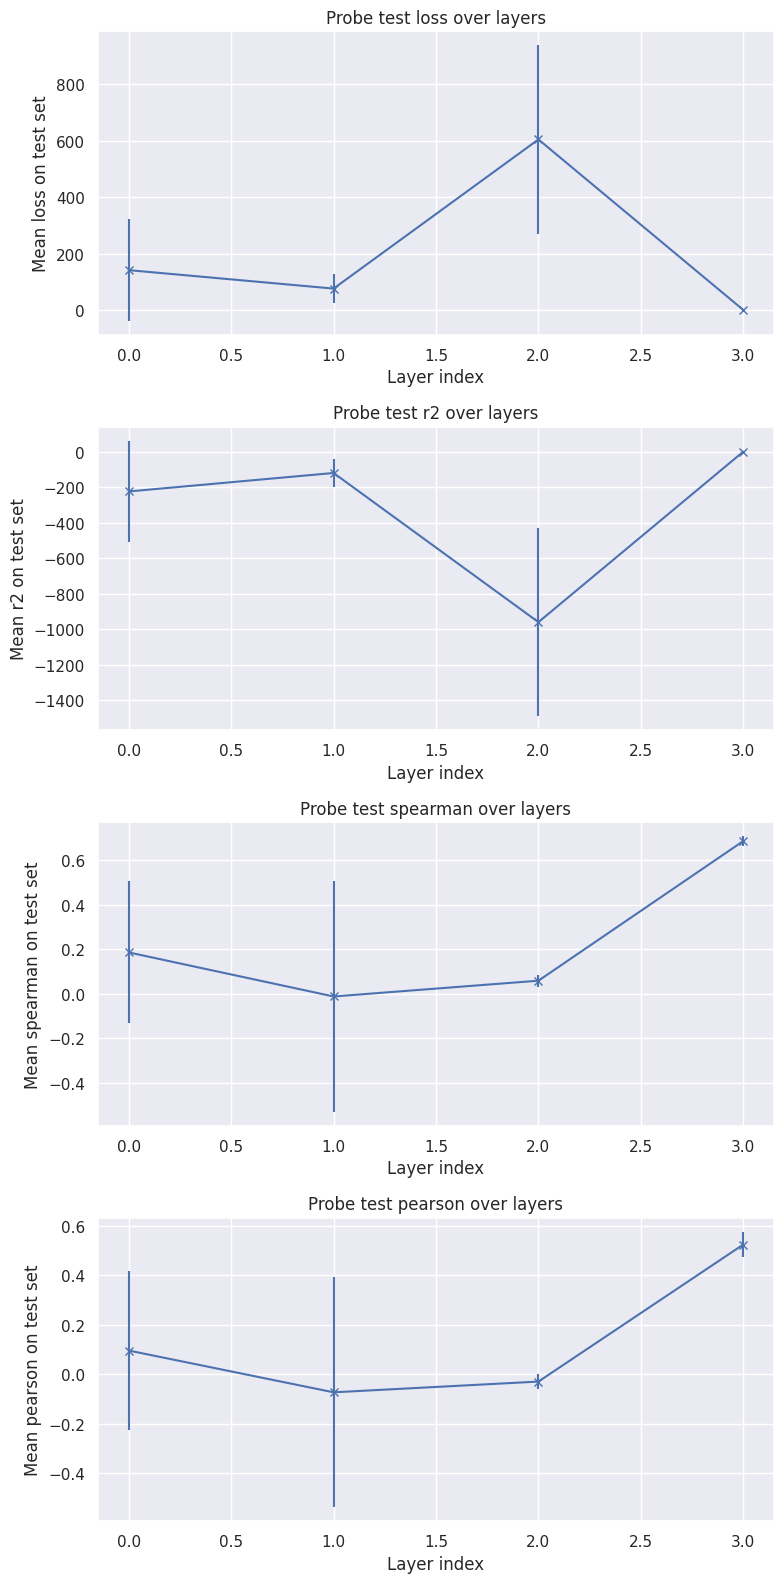

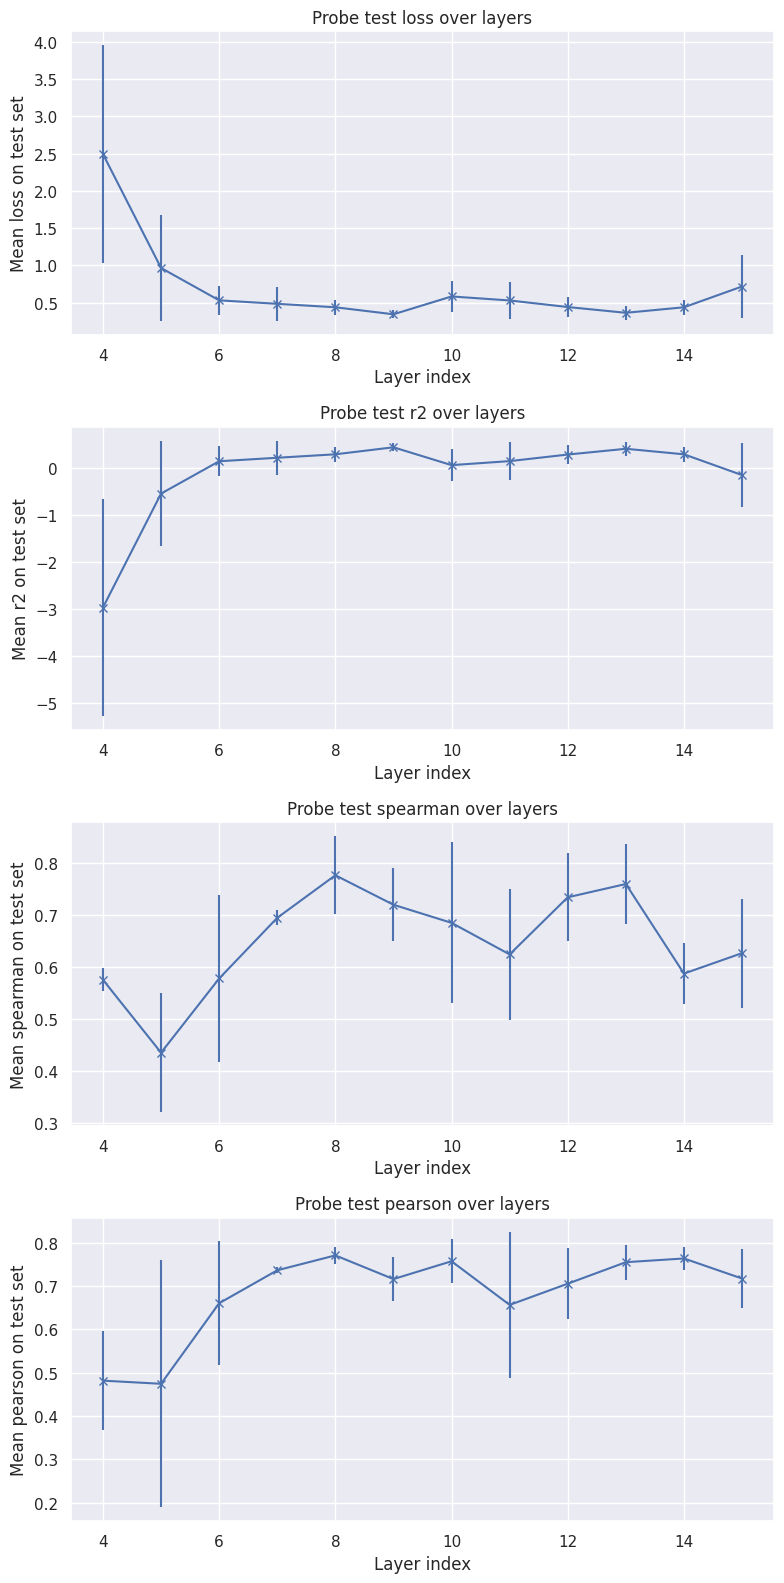

In [ ]:
# load expt results
with open(f'{probes_path_0}/experiment_data.pt', 'rb') as f:
    expt_results = pickle.load(f)
expt_summary = expt_utils.summarise_experiment(expt_results, incl_extras = True)

# plot encoder layers
expt_utils.plot_from_summary(expt_summary, incl_extras = True, descriptor='derivative_0', layers = [0,1,2,3])

# plot decover layers
expt_utils.plot_from_summary(expt_summary, incl_extras = True, descriptor='derivative_0', layers = range(4,16))

In [ ]:
expt_summary

,layer,r2_mean,r2_std,spearman_mean,spearman_std,pearson_mean,pearson_std,loss_mean,loss_std
0,0,-224.135853,285.951826,0.185506,0.319096,0.095041,0.322803,141.656815,179.922585
1,1,-120.261865,79.882215,-0.012303,0.518512,-0.073908,0.465589,76.298685,50.262364
2,2,-959.448815,530.684860,0.058530,0.027526,-0.030455,0.029356,604.320090,333.910058
3,3,-0.244687,0.295715,0.685519,0.022127,0.523680,0.052227,0.783164,0.186066
4,4,-2.962898,2.320703,0.575233,0.022562,0.481456,0.113964,2.493479,1.460200
5,5,-0.535690,1.123326,0.434739,0.114278,0.474238,0.285185,0.966265,0.706803
6,6,0.153342,0.315417,0.577729,0.161537,0.659977,0.143081,0.532722,0.198462
7,7,0.227713,0.365007,0.694657,0.014557,0.735950,0.006743,0.485927,0.229665
8,8,0.301359,0.164043,0.776713,0.075423,0.770313,0.018876,0.439589,0.103217
9,9,0.450685,0.082055,0.719860,0.070021,0.715707,0.050748,0.345632,0.051630


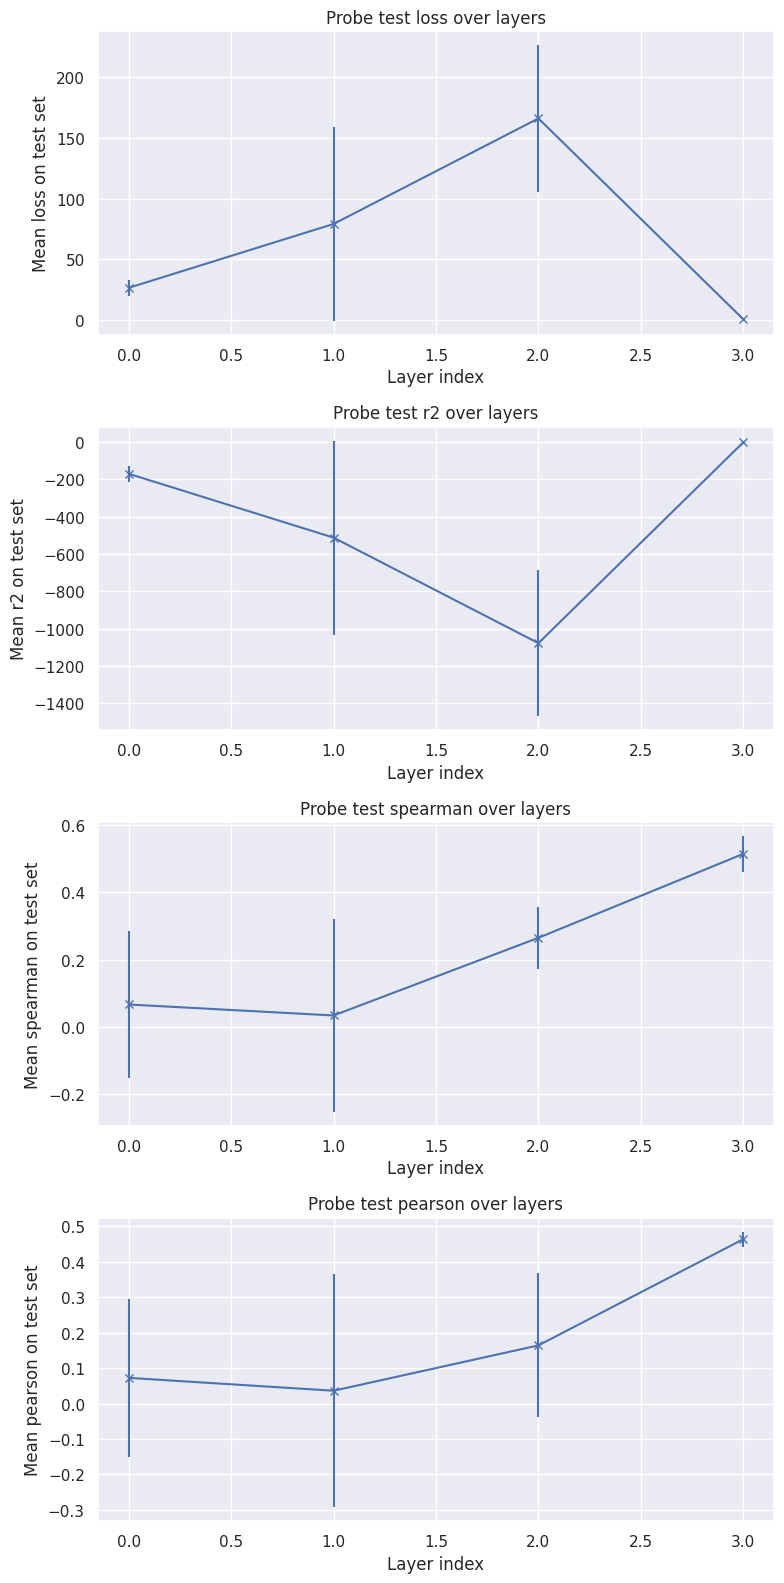

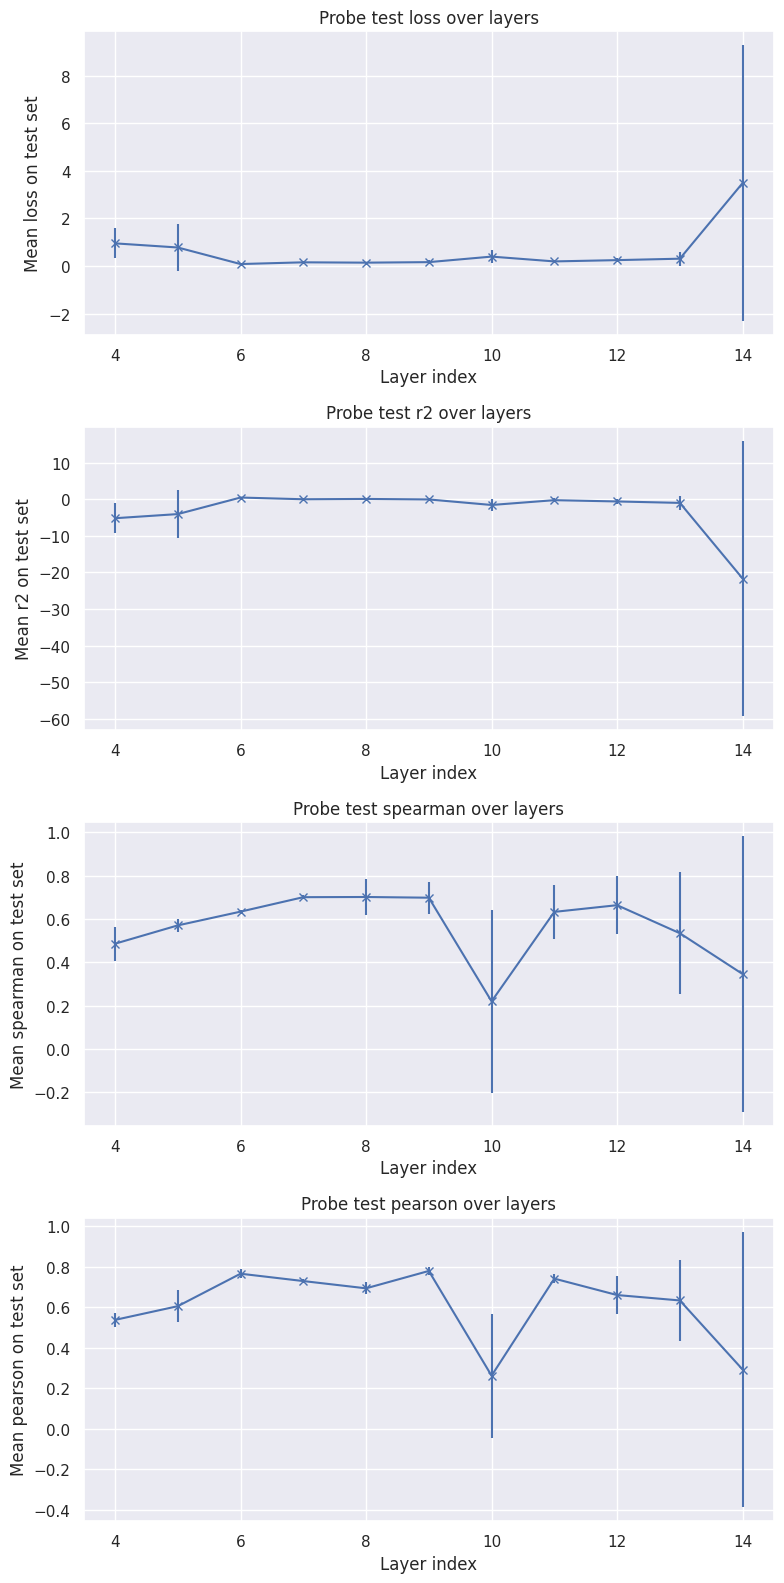

In [ ]:
# load experiment results
with open(f'{probes_path_3}/experiment_data.pt', 'rb') as f:
    expt_results = pickle.load(f)
expt_summary = expt_utils.summarise_experiment(expt_results, incl_extras = True)
expt_utils.plot_from_summary(expt_summary, incl_extras = True, descriptor='derivative_3', layers=[0,1,2,3])

expt_utils.plot_from_summary(expt_summary, incl_extras = True, descriptor='derivative_3', layers=range(4,15))

In [ ]:
expt_summary

,layer,r2_mean,r2_std,spearman_mean,spearman_std,pearson_mean,pearson_std,loss_mean,loss_std
0,0,-170.058619,43.498063,0.066835,0.218004,0.072625,0.222634,26.334228,6.696464
1,1,-512.442836,520.182611,0.034141,0.286919,0.036297,0.329354,79.043787,80.081366
2,2,-1078.341968,393.030891,0.265114,0.092366,0.164229,0.203266,166.163146,60.506540
3,3,-1.414798,1.235799,0.514759,0.052766,0.463887,0.021343,0.371755,0.190249
4,4,-5.187380,4.079502,0.485888,0.078039,0.536876,0.036479,0.952538,0.628033
5,5,-4.057423,6.456093,0.570475,0.030020,0.604581,0.079931,0.778583,0.993906
6,6,0.464822,0.097069,0.634039,0.008013,0.764980,0.023408,0.082390,0.014944
7,7,-0.006593,0.413248,0.700876,0.010269,0.728694,0.010805,0.154964,0.063619
8,8,0.084669,0.210986,0.701712,0.081418,0.692809,0.029449,0.140914,0.032481
9,9,-0.057042,0.449192,0.698443,0.073950,0.778594,0.021500,0.162730,0.069152


In [ ]:
expt_summary[expt_summary['layer']<4]

,layer,r2_mean,r2_std,spearman_mean,spearman_std,pearson_mean,pearson_std,loss_mean,loss_std
0,0,-170.058619,43.498063,0.066835,0.218004,0.072625,0.222634,26.334228,6.696464
1,1,-512.442836,520.182611,0.034141,0.286919,0.036297,0.329354,79.043787,80.081366
2,2,-1078.341968,393.030891,0.265114,0.092366,0.164229,0.203266,166.163146,60.506540
3,3,-1.414798,1.235799,0.514759,0.052766,0.463887,0.021343,0.371755,0.190249
